<a href="https://colab.research.google.com/github/jacheung/still-learning/blob/master/autocurator_CNN_v1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import necessary libraries
import tensorflow as tf 
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
import sklearn.model_selection as ms
from google.colab import drive
import h5py

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [8]:
# test h5py files 
filename = '/content/gdrive/My Drive/Colab Notebooks/myfile.h5'
f = h5py.File(filename, 'r')


AttributeError: ignored

In [ ]:
# Load datasets 
raw_X = np.load('/content/gdrive/My Drive/Colab Notebooks/AH0000x000000-1_dataset.npy')
raw_Y = np.load('/content/gdrive/My Drive/Colab Notebooks/AH0000x000000-1_touchClass.npy').astype(int)

## 1) Data cleaning  
In this section we're going to convert the images to the right channels and dimensions for MobileNetV2. 

a. many of the pre-trained models require 3 channels instead of 1  
b. many of the pre-trained models also require specific image dimensions 

In [ ]:
# a. 3 channel conversion - convert grayscale image (1 channel) to rgb image (3 channel) for pretrained networks
print('raw image size = ' + str(raw_X.shape))  # (64, 224, 224)
rgb_batch = np.repeat(raw_X[..., np.newaxis], 3, -1)
print('converted rgb image size = ' + str(rgb_batch.shape))

raw image size = (732, 61, 61)
converted rgb image size = (732, 61, 61, 3)


In [ ]:
# b. image resizing

IMG_SIZE = 96 # All images will be resized to 160x160. This is the size of MobileNetV2 input sizes

rgb_tensor = tf.cast(rgb_batch, tf.float32) # convert to tf tensor with float32 dtypes
rgb_tensor = (rgb_tensor/127.5) - 1 # /127.5 = 0:2, -1 = -1:1 requirement for mobilenetV2
rgb_tensor = tf.image.resize(rgb_tensor, (IMG_SIZE, IMG_SIZE)) # resizing

IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

rgb_tensor.shape

TensorShape([732, 96, 96, 3])

# 2) Basic EDA  
We're going to verify that the data looks good by eye. 



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


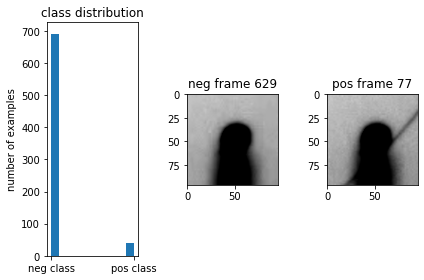

In [ ]:
# Look at the distribution of classes
fig, axs = plt.subplots(1, 3)
axs[0].hist(raw_Y)
axs[0].set_title('class distribution')
axs[0].set_xticks([0,1])
axs[0].set_xticklabels(['neg class', 'pos class'])
axs[0].set_ylabel('number of examples')

# Look at some images of positive and negative
neg_class = [i for i, val in enumerate(raw_Y) if val==0]
pos_class = [i for i, val in enumerate(raw_Y) if val==1]
axs[1].imshow(rgb_tensor[np.random.choice(neg_class,1)[0]])
axs[1].set_title('neg frame ' + str(np.random.choice(neg_class,1)[0]))
axs[2].imshow(rgb_tensor[np.random.choice(pos_class,1)[0]])
axs[2].set_title('pos frame ' + str(np.random.choice(pos_class,1)[0]))
plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

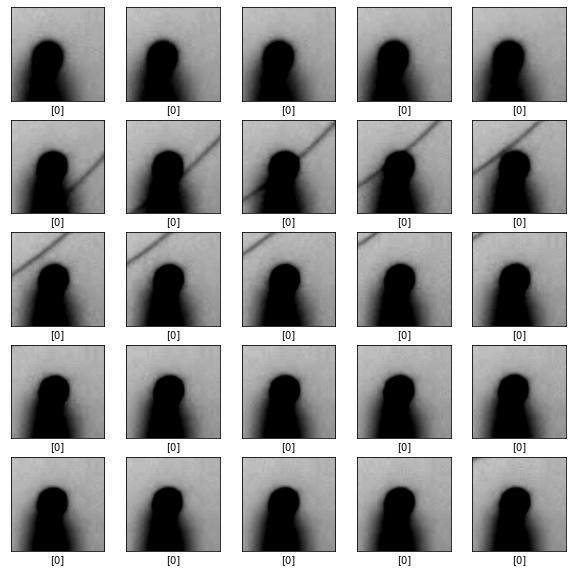

In [ ]:
# Plot first 25 trials and see what they look like 
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(rgb_tensor[i])
    plt.xlabel(str(raw_Y[i]))
plt.show()

#3) Feature engineering and test/train splits

In [ ]:
#3) Feature engineering and train test split

X_train,X_test,Y_train,Y_test = ms.train_test_split(rgb_tensor.numpy(), raw_Y , test_size=0.2)
X_train,X_val,Y_train,Y_val= ms.train_test_split(X_train, Y_train, test_size=0.2)

print('train = ' + str(X_train.shape[0]))
print('test = ' + str(X_val.shape[0]))
print('validation = ' + str(X_test.shape[0]))

train = 468
test = 117
validation = 147


# 4) Deploy and selection of base model
In this section we're going to use MobileNetV2 as the base model.
We're going to run two variations of the model.  
a. basemodel with frozen layers and output classifer changes   
b. basemodel with final 100 layers unfrozen to optimize prediction 


In [ ]:
# Create base model 

# First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the include_top=False argument, 
# you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

feature_batch = base_model(rgb_tensor)
print(feature_batch.shape)

# Adding Classification head
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

# Model Stacking
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

print(model.summary())

# Compile model with specific metrics
# Metrics below are for evaluating imbalanced datasets
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name = 'auc')
]

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=METRICS)



(732, 3, 3, 1280)
(732, 1280)
(732, 1)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Model)  (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________
None


In [ ]:
# Fit model with a couple parameters
EPOCHS = 20

# Class imbalance weighting
rebalance = class_weight.compute_class_weight('balanced',
                                  np.unique(Y_train), Y_train.flatten())
class_weights = {i : rebalance[i] for i in range(2)}

# Early stopping 
callbacks = [keras.callbacks.EarlyStopping (monitor = 'val_loss',
                                            patience = 2)]

history = model.fit(X_train, Y_train, epochs=EPOCHS,
              validation_data=(X_val, Y_val),
              callbacks = callbacks,
              class_weight = class_weights)

Epoch 1/20
15/15 [==============================] - 4s 268ms/step - loss: 0.0974 - tp: 26.0000 - fp: 11.0000 - tn: 431.0000 - fn: 0.0000e+00 - precision: 0.7027 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.1125 - val_tp: 5.0000 - val_fp: 3.0000 - val_tn: 109.0000 - val_fn: 0.0000e+00 - val_precision: 0.6250 - val_recall: 1.0000 - val_auc: 0.9991
Epoch 2/20
15/15 [==============================] - 4s 268ms/step - loss: 0.0974 - tp: 26.0000 - fp: 11.0000 - tn: 431.0000 - fn: 0.0000e+00 - precision: 0.7027 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.1125 - val_tp: 5.0000 - val_fp: 3.0000 - val_tn: 109.0000 - val_fn: 0.0000e+00 - val_precision: 0.6250 - val_recall: 1.0000 - val_auc: 0.9991
Epoch 3/20
15/15 [==============================] - 4s 275ms/step - loss: 0.0974 - tp: 26.0000 - fp: 11.0000 - tn: 431.0000 - fn: 0.0000e+00 - precision: 0.7027 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.1125 - val_tp: 5.0000 - val_fp: 3.0000 - val_tn: 109.0000 - val_fn: 0.0000e+00 - val_precision: 0.

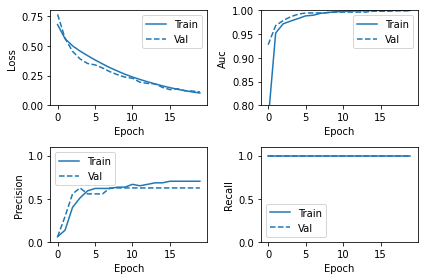

In [ ]:
# Model evaluation
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1.1])

    plt.legend()
    plt.tight_layout()

plot_metrics(history)

In [ ]:
# Model prediction

prediction = model.predict(X_test)


#5) Hyperparameter tuning of best base model 

In [ ]:
# Fine-tuning model by unfreezing layers and allowing them to be trainable

model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in model.layers[:fine_tune_at]:
  layer.trainable =  False

# Compile model with specific metrics
# Metrics below are for evaluating imbalanced datasets
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name = 'auc')
]

# compile model with a much slower learning rate 
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=METRICS)


Number of layers in the base model:  3


In [ ]:
# Fit model with class imbalance weighting

rebalance = class_weight.compute_class_weight('balanced',
                                  np.unique(Y_train), Y_train.flatten())
class_weights = {i : rebalance[i] for i in range(2)}

history = model.fit(X_train, Y_train, epochs=10,
              validation_data=(X_val, Y_val),
              class_weight=class_weights)

Epoch 1/10
15/15 [==============================] - 6s 372ms/step - loss: 0.0974 - tp: 26.0000 - fp: 11.0000 - tn: 431.0000 - fn: 0.0000e+00 - precision: 0.7027 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.1125 - val_tp: 5.0000 - val_fp: 3.0000 - val_tn: 109.0000 - val_fn: 0.0000e+00 - val_precision: 0.6250 - val_recall: 1.0000 - val_auc: 0.9991
Epoch 2/10
15/15 [==============================] - 4s 288ms/step - loss: 0.0974 - tp: 26.0000 - fp: 11.0000 - tn: 431.0000 - fn: 0.0000e+00 - precision: 0.7027 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.1125 - val_tp: 5.0000 - val_fp: 3.0000 - val_tn: 109.0000 - val_fn: 0.0000e+00 - val_precision: 0.6250 - val_recall: 1.0000 - val_auc: 0.9991
Epoch 3/10
15/15 [==============================] - ETA: 0s - loss: 0.0974 - tp: 26.0000 - fp: 11.0000 - tn: 431.0000 - fn: 0.0000e+00 - precision: 0.7027 - recall: 1.0000 - auc: 1.0000

KeyboardInterrupt: ignored